**Plant Seedlings Identification from Picture using CNN:** 
 The goal is to create a classifier capable of determining a plant's species from a photo

# Importing all necessary Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt              # Import matplotlib.pyplot (Plotting framework in Python.)
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras import layers
from sklearn import svm
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow      # To show images using cv2 module
from skimage import data, io   # Import skimage library (data - Test images and example data.
                #io - Reading, saving, and displaying images.) 
import os       # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score



# Mount the drive in google colab and extract the data in to folder(IMAGE) from the zip

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
#train_path = "/content/sample_data/plant-seedlings-classification.zip"
train_path = "/content/drive/MyDrive/ANN_COLAB/IMAGE/train.zip"
train_path

'/content/drive/MyDrive/ANN_COLAB/IMAGE/train.zip'

In [ ]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir /content/drive/MyDrive/Colab_Notebooks/IMAGE

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab_Notebooks/IMAGE’: No such file or directory


In [ ]:
# Extract the files from dataset, as the dataset is as zip file.

# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/ANN_COLAB/IMAGE/train.zip', 'r') as zip:
  zip.extractall('/content/drive/MyDrive/ANN_COLAB/plant')
  zip.close()

In [ ]:
# print the directory content
zip.printdir()

File Name                                             Modified             Size
Black-grass/0050f38b3.png                      2019-12-11 23:36:08        54973
Black-grass/0183fdf68.png                      2019-12-11 23:36:10       226795
Black-grass/0260cffa8.png                      2019-12-11 23:36:10      1096684
Black-grass/05eedce4d.png                      2019-12-11 23:36:14        20870
Black-grass/075d004bc.png                      2019-12-11 23:36:16       313104
Black-grass/078eae073.png                      2019-12-11 23:36:16      1689987
Black-grass/082314602.png                      2019-12-11 23:36:16        94991
Black-grass/0ace21089.png                      2019-12-11 23:36:18      5382683
Black-grass/0b228a6b8.png                      2019-12-11 23:36:20       416906
Black-grass/0b3e7a7a9.png                      2019-12-11 23:36:20       170238
Black-grass/0bb75ded8.png                      2019-12-11 23:36:20      4821936
Black-grass/0be707615.png               

# Data Pre-Processing

In [ ]:
import cv2
path = "/content/drive/MyDrive/ANN_COLAB/plant/*/*.png"            
#path =  "./temp_train/*/*.png"                   # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1
trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set
x = trainImg
y = trainLabel



In [ ]:
trainImg_path = "/content/drive/MyDrive/ANN_COLAB/plant"
lbl_classes = {}
for class_name in os.listdir(trainImg_path):
    lbl_classes[class_name] = len(os.listdir(os.path.join(trainImg_path, class_name)))
print(lbl_classes)

{'Black-grass': 263, 'Charlock': 390, 'Cleavers': 287, 'Common Chickweed': 611, 'Common wheat': 221, 'Fat Hen': 475, 'Loose Silky-bent': 654, 'Maize': 221, 'Scentless Mayweed': 516, 'Shepherds Purse': 231, 'Small-flowered Cranesbill': 496, 'Sugar beet': 385}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

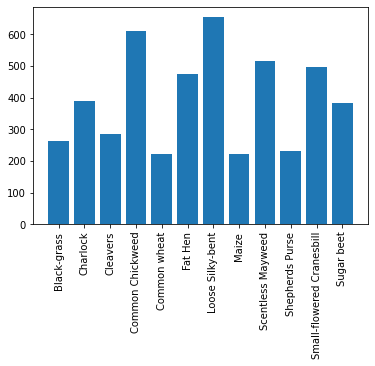

In [ ]:
#Bar Plot - for visualization of different classes of Plants
plt.bar(lbl_classes.keys(), lbl_classes.values())
plt.xticks(rotation=90)

Apply Gaussian blurring as part of preprocessing to soften sphere edges which often contain irregularities due to the rough surface of the marker.
Gaussian blurring is commonly used when reducing the size of an image. When downsampling an image, it is common to apply a low-pass filter to the image prior to resampling. This is to ensure that spurious high-frequency information does not appear in the downsampled image (aliasing).

# Apply Gaussian blurring to Soften the sphere edges and Visualize Sample Pictures

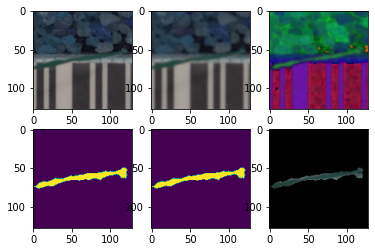

In [ ]:
trainImg_blur = []
sets = []; getEx = True

for i in trainImg:
    #1- Use gaussian blur
    gaus_blurr = cv2.GaussianBlur(i,(5,5),0)

    #2- Convert to HSV image
    cnv_2_hsv = cv2.cvtColor(gaus_blurr,cv2.COLOR_BGR2HSV)
    
    #3- Create mask (parameters - green color range)
    lower = (25,40,50)
    upper = (75,255,255)
    
    mask = cv2.inRange(cnv_2_hsv,lower,upper)
    
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))

    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)

    #4- Create boolean mask
    boolean = mask > 0

    #5- Create empty image
    new = np.zeros_like(i,np.uint8)

    #6- Apply boolean mask to the original image
    new[boolean] = i[boolean]

    #7- Append adds object to the end of the list - image without background  
    trainImg_blur.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # original
        plt.subplot(2,3,2);plt.imshow(gaus_blurr) # blurred
        plt.subplot(2,3,3);plt.imshow(cnv_2_hsv) # converted into HSV
        plt.subplot(2,3,4);plt.imshow(mask) # masked
        plt.subplot(2,3,5);plt.imshow(boolean) # boolean masked
        plt.subplot(2,3,6);plt.imshow(new) # new processed image
        plt.show()
        getEx = False
#new_trainImg = np.asarray(trainImg_blur)
trainImg = np.asarray(trainImg_blur)

# Splitting the RGB pixels in the images and visualize

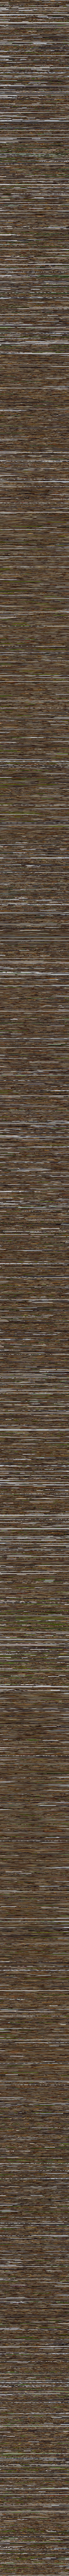

In [ ]:
# Getting the red channel of images
image_red_channel = trainImg[:,:,0]
cv2_imshow(image_red_channel)

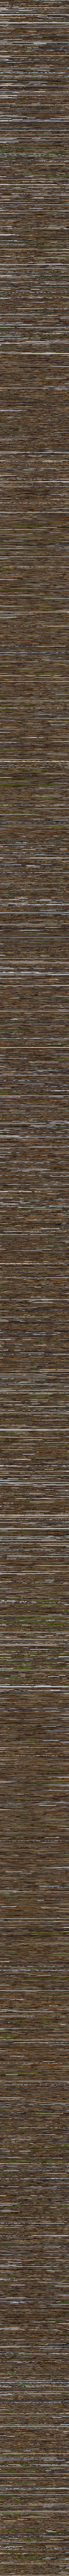

In [ ]:
# Getting the Green channel of images
image_green_channel = trainImg[:,:,1]
cv2_imshow(image_green_channel)

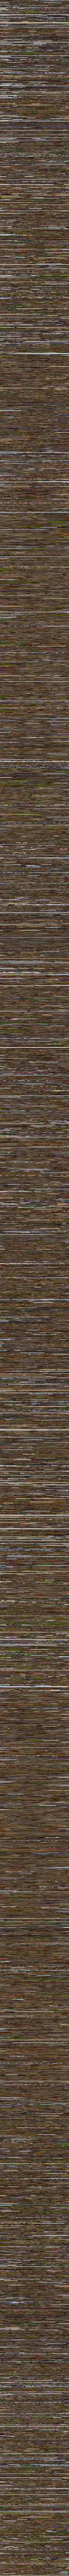

In [ ]:
# Getting the Blue channel of images
image_blue_channel = trainImg[:,:,2]
cv2_imshow(image_blue_channel)

In [ ]:
print(trainImg)


[[[[ 24  47  77]
   [ 33  54  81]
   [ 45  66  89]
   ...
   [ 55  78  88]
   [ 60  86  94]
   [ 52  83  90]]

  [[ 21  46  79]
   [ 36  57  86]
   [ 46  66  90]
   ...
   [ 59  77  88]
   [ 62  81  92]
   [ 57  77  89]]

  [[ 24  49  82]
   [ 31  54  84]
   [ 50  69  95]
   ...
   [ 57  72  84]
   [ 58  72  85]
   [ 61  77  89]]

  ...

  [[155 149 143]
   [156 150 144]
   [154 149 143]
   ...
   [142 136 132]
   [ 97  92  91]
   [ 67  61  67]]

  [[155 149 142]
   [156 150 142]
   [152 147 141]
   ...
   [140 135 130]
   [ 93  87  87]
   [ 60  54  59]]

  [[156 149 142]
   [155 149 141]
   [153 147 139]
   ...
   [140 133 129]
   [ 91  85  84]
   [ 64  58  62]]]


 [[[ 42  48  56]
   [ 50  56  66]
   [ 51  55  69]
   ...
   [ 84 104 119]
   [103 123 131]
   [ 95 114 128]]

  [[ 43  49  57]
   [ 49  55  63]
   [ 46  53  66]
   ...
   [ 84 101 119]
   [ 85 103 118]
   [ 75  95 110]]

  [[ 49  55  68]
   [ 47  55  64]
   [ 50  63  69]
   ...
   [ 73  87 104]
   [ 61  75 100]
   [ 51  74

In [ ]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 40
num_predictions = 20

# Create a dictionary for the label of the Plants

In [ ]:
label_dict =  {0:'Loose Silky-bent', 1:'Common Chickweed', 2:'Scentless Mayweed', 3:'Small-flowered Cranesbill', 4:'Fat Hen', 5:'Charlock', 6:'Sugar beet', 7:'Cleavers', 8:'Black-grass', 9:'Shepherds Purse', 10:'Maize', 11:'Common wheat'}

# Split the Preprocessed Data into train, validation and test set data

In [ ]:
x_train, X_test, y_train, Y_test = train_test_split(trainImg, y, test_size=0.3, random_state=4, stratify=y)
x_cv, x_test, y_cv, y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=4, stratify=Y_test)

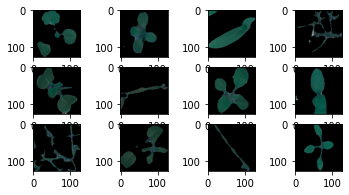

In [ ]:
i = 0
for i in range(12):
  plt.subplot(4, 4, i+1)
  #plt.subplot()
  image = x_train[i]
  label = y_train[0].iloc[i]
  #print(' Label \n Label Id: {} \n Name: {}'.format(label, label_dict[label]))
  #print(f'Label \n Label Id: {label} \n Name: {label_dict[label]}')
  plt.imshow(image);

In [ ]:
# Print the shape of dataset.
print('x_train shape:', x_train.shape)
print('x_cv shape:', x_cv.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_cv.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3325, 128, 128, 3)
x_cv shape: (712, 128, 128, 3)
x_test shape: (713, 128, 128, 3)
3325 train samples
712 validation samples
713 test samples


In [ ]:
# We can see that each digit is made of 784 pixels.
x_train[0].shape

(128, 128, 3)

In [ ]:
print('y_train.shape:', y_train.shape)


y_train.shape: (3325, 1)


# Print y[0]

In [ ]:
y_train[0]

4123    Small-flowered Cranesbill
3671              Shepherds Purse
3054                        Maize
2537             Loose Silky-bent
628                      Charlock
                  ...            
1224             Common Chickweed
2797             Loose Silky-bent
1855                      Fat Hen
3079                        Maize
4325    Small-flowered Cranesbill
Name: 0, Length: 3325, dtype: object

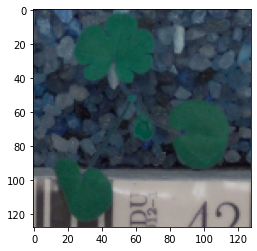

In [ ]:
plt.imshow(x_train[0])

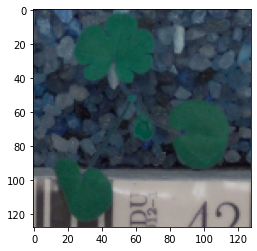

In [ ]:

# Plot the de-noised image generated by applying Gaussian blur.
plt.imshow(x_train[0], cmap='gray')

In [ ]:
x_train[9, :, :, :].shape

(128, 128, 3)

In [ ]:
x_test[2, :, :, :]

array([[[0.36078432, 0.43137255, 0.48235294],
        [0.25882354, 0.34117648, 0.4       ],
        [0.16078432, 0.21176471, 0.29803923],
        ...,
        [0.2627451 , 0.33333334, 0.40392157],
        [0.34509805, 0.40784314, 0.4627451 ],
        [0.38039216, 0.44705883, 0.49411765]],

       [[0.3137255 , 0.38431373, 0.44705883],
        [0.2       , 0.25882354, 0.32941177],
        [0.11764706, 0.15686275, 0.24705882],
        ...,
        [0.27058825, 0.3372549 , 0.39607844],
        [0.34117648, 0.4       , 0.44705883],
        [0.28627452, 0.34509805, 0.41568628]],

       [[0.20392157, 0.26666668, 0.34901962],
        [0.16470589, 0.21568628, 0.28627452],
        [0.13725491, 0.18431373, 0.24705882],
        ...,
        [0.14509805, 0.19215687, 0.27058825],
        [0.15294118, 0.2       , 0.26666668],
        [0.11764706, 0.16862746, 0.27450982]],

       ...,

       [[0.16862746, 0.16078432, 0.18039216],
        [0.16078432, 0.15686275, 0.16862746],
        [0.16470589, 0

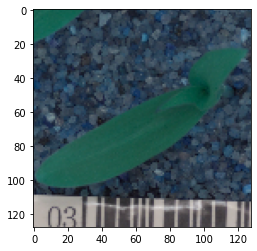

In [ ]:
plt.imshow(x_train[2])

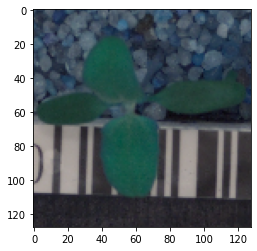

In [ ]:
plt.imshow(x_test[2])

In [ ]:
y_train.shape

(3325, 1)

In [ ]:
print(y)

                0
0     Black-grass
1     Black-grass
2     Black-grass
3     Black-grass
4     Black-grass
...           ...
4745   Sugar beet
4746   Sugar beet
4747   Sugar beet
4748   Sugar beet
4749   Sugar beet

[4750 rows x 1 columns]


In [ ]:
y[0][654]

'Cleavers'

# Value count of each species

In [ ]:
#g = sns.countplot(y)
y.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [ ]:
x.shape

(4750, 128, 128, 3)

In [ ]:
# see the lable at 4325 location
y_train[0][4325]

'Small-flowered Cranesbill'

In [ ]:
label_dict =  {0:'Loose Silky-bent', 1:'Common Chickweed', 2:'Scentless Mayweed', 3:'Small-flowered Cranesbill', 4:'Fat Hen', 5:'Charlock', 6:'Sugar beet', 7:'Cleavers', 8:'Black-grass', 9:'Shepherds Purse', 10:'Maize', 11:'Common wheat'}

# Convert  multi-class labels to binary labels using LabelBinarizer

In [ ]:
# Convert  multi-class labels to binary labels using LabelBinarizer
# LabelBinarizer makes this process easy with the transform method.

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_cv = enc.fit_transform(y_cv)
y_test = enc.fit_transform(y_test)

In [ ]:
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(3325, 12)
(712, 12)
(713, 12)


In [ ]:
y_train[2]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

# Apply one hot encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
#y = [[0], [1], [2], [3]]
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]
#keras.utils.to_categorical(y)
#ohe = OneHotEncoder()
#ohe.fit_transform(y).toarray()
pd.get_dummies(y)

0   1   2   3   4   5   6   7   8   9   10  11
0    1   0   0   0   0   0   0   0   0   0   0   0
1    0   1   0   0   0   0   0   0   0   0   0   0
2    0   0   1   0   0   0   0   0   0   0   0   0
3    0   0   0   1   0   0   0   0   0   0   0   0
4    0   0   0   0   1   0   0   0   0   0   0   0
5    0   0   0   0   0   1   0   0   0   0   0   0
6    0   0   0   0   0   0   1   0   0   0   0   0
7    0   0   0   0   0   0   0   1   0   0   0   0
8    0   0   0   0   0   0   0   0   1   0   0   0
9    0   0   0   0   0   0   0   0   0   1   0   0
10   0   0   0   0   0   0   0   0   0   0   1   0
11   0   0   0   0   0   0   0   0   0   0   0   1

# Normalisation of Data

In [ ]:
x_train = x_train.astype('float32') # Conversion to float type from integer type.
x_test = x_test.astype('float32')
x_cv = x_cv.astype('float32')
x_train /= 255.0 # Division by 255
x_cv /= 255.0
x_test /= 255.0

# Build Sequential Model with Batch Normalization and Max Pooling

In [ ]:
# Set the CNN model

import tensorflow as tf

model = tf.keras.Sequential()
model.add(layers.Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=x_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

# Apply Adam optimizer and Categorical_Crossentrophy

In [ ]:
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [ ]:
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training
filepath = "weights.hdf5"

if os.path.isfile(filepath):
 model.load_weights(filepath)


model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, mode='max')


# Reshape data into shapes compatible with Keras models

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 128, 128, 3)
x_test = x_test.reshape(x_test.shape[0], 128,128, 3)
x_cv= x_cv.reshape(x_cv.shape[0], 128,128, 3)


print(x_train.shape)
print(x_test.shape)
print(x_cv.shape)

(3325, 128, 128, 3)
(713, 128, 128, 3)
(712, 128, 128, 3)


# Fit the Model

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_cv, y_cv),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,checkpoint])

Epoch 1/50
104/104 [==============================] - 42s 79ms/step - loss: 0.1227 - accuracy: 0.1229 - val_loss: 0.0769 - val_accuracy: 0.0955
Epoch 2/50
104/104 [==============================] - 7s 64ms/step - loss: 0.0752 - accuracy: 0.2433 - val_loss: 0.0782 - val_accuracy: 0.0955
Epoch 3/50
104/104 [==============================] - 7s 65ms/step - loss: 0.0658 - accuracy: 0.3277 - val_loss: 0.0830 - val_accuracy: 0.0604
Epoch 4/50
104/104 [==============================] - 7s 65ms/step - loss: 0.0622 - accuracy: 0.3804 - val_loss: 0.0916 - val_accuracy: 0.0604
Epoch 5/50
104/104 [==============================] - 7s 65ms/step - loss: 0.0587 - accuracy: 0.4435 - val_loss: 0.0762 - val_accuracy: 0.1166
Epoch 6/50
104/104 [==============================] - 7s 65ms/step - loss: 0.0560 - accuracy: 0.4723 - val_loss: 0.0627 - val_accuracy: 0.4213
Epoch 7/50
104/104 [==============================] - 7s 65ms/step - loss: 0.0531 - accuracy: 0.5128 - val_loss: 0.0562 - val_accuracy: 0.497

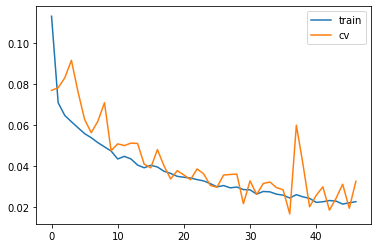

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='cv')
plt.legend()
plt.show()

# Evaluate the Model with Test data

In [ ]:
# Score trained model.
results = model.evaluate(x_test, y_test)
print(results)
print('Test loss:', results[0])
print('Test accuracy:', results[1])
# For final model improvement, use Keras Tuner for HyperParameter Tuning

23/23 [==============================] - 1s 33ms/step - loss: 0.0317 - accuracy: 0.7279
[0.03173103183507919, 0.7279102206230164]
Test loss: 0.03173103183507919
Test accuracy: 0.7279102206230164


In [ ]:
print(model.metrics_names)
print(results)

['loss', 'accuracy']
[0.03173103183507919, 0.7279102206230164]


In [ ]:
Y_pred_cls = model.predict_classes(x_test, batch_size=200, verbose=0)

print('Accuracy Model1 (Dropout): '+ str(model.evaluate(x_test,y_test)))

23/23 [==============================] - 0s 17ms/step - loss: 0.0317 - accuracy: 0.7279
Accuracy Model1 (Dropout): [0.03173103183507919, 0.7279102206230164]


In [ ]:
rounded_lab = np.argmax(y_test,axis=1)
rounded_lab

array([10, 10,  5, 10,  9,  6,  6,  3,  8,  6,  6,  5,  6,  4,  9, 11,  1,
       11,  1,  1,  9,  8,  9,  3, 11,  1,  1,  1, 10,  8,  6,  1,  5,  6,
        0, 10,  0,  3,  9,  6,  6,  6,  2,  8, 10,  1,  5,  8,  5,  0,  1,
       11, 10,  0,  8,  3,  7,  3,  8, 10,  5,  3,  3, 11,  1,  2, 10,  5,
        5,  6, 11,  2, 11,  6,  6,  5,  7,  6,  2,  0,  6,  6,  6, 10,  5,
        8,  3,  5,  2,  9,  8,  4,  7, 11, 11, 11,  0,  1,  6, 10,  6,  3,
        6,  8,  8,  1,  4,  0,  5, 10,  3,  2,  5,  6,  5,  3,  6,  0,  3,
        6,  5, 11,  7,  2,  6,  5,  5,  3, 11,  0, 10,  2,  1,  1, 10,  8,
        6,  5,  3,  0,  3,  6,  5,  9,  6,  6,  6,  6,  0,  8,  9,  3, 10,
        6,  1,  9,  1,  7,  0,  0, 11, 10,  6,  3,  4, 10,  1,  8, 11,  3,
        9,  0,  8,  5,  5,  6,  8,  8,  8,  4,  5,  3,  6,  8,  7,  6,  1,
        9,  6,  1,  6,  9, 10,  5,  0,  4,  3,  3,  3,  8,  8, 10, 11,  8,
        8,  3, 11,  0,  9,  3,  7,  5,  3,  3,  8,  9,  4,  4, 11,  9,  8,
        2,  3,  6, 10,  0

# Print the confusion matrix and classification report and its metrics

Classification Matrix

              precision    recall  f1-score   support

           0       0.79      0.28      0.42        39
           1       0.86      0.64      0.73        58
           2       0.44      0.98      0.60        43
           3       0.95      0.63      0.76        92
           4       0.74      0.70      0.72        33
           5       0.92      0.90      0.91        72
           6       0.74      0.94      0.83        98
           7       1.00      0.48      0.65        33
           8       0.82      0.59      0.69        78
           9       1.00      0.29      0.45        34
          10       0.50      0.93      0.65        75
          11       0.94      0.84      0.89        58

    accuracy                           0.73       713
   macro avg       0.81      0.68      0.69       713
weighted avg       0.80      0.73      0.72       713

Confusion Matrix

[[11  0  0  0  5  1 22  0  0  0  0  0]
 [ 0 37 19  0  0  0  0  0  0  0  2  0]
 [ 0  0 42  0 

<function matplotlib.pyplot.show>

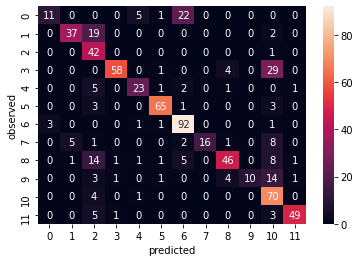

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion = classification_report(rounded_lab, Y_pred_cls)
matrix = confusion_matrix(rounded_lab,Y_pred_cls)
#print(classification_report(y_true, y_pred))
print('Classification Matrix\n')
print(confusion)
print('Confusion Matrix\n')
print(matrix)
import seaborn as sns
sns.heatmap(matrix, annot = True)
plt.ylabel('observed')
plt.xlabel('predicted')
plt.show

# Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

label_dict =  {0:'Loose Silky-bent', 1:'Common Chickweed', 2:'Scentless Mayweed', 3:'Small-flowered Cranesbill', 4:'Fat Hen', 5:'Charlock', 6:'Sugar beet', 7:'Cleavers', 8:'Black-grass', 9:'Shepherds Purse', 10:'Maize', 11:'Common wheat'}

label:[0 0 0 0 0 0 0 0 0 0 1 0]
Predict:  Maize


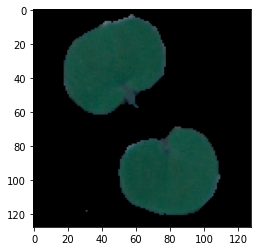

In [ ]:
#Visaulize Predictions for x_test[59]
i=59
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[0 0 0 0 0 1 0 0 0 0 0 0]
Predict:  Charlock


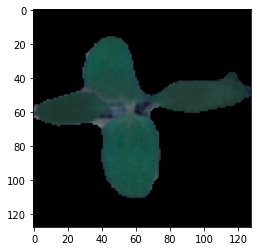

In [ ]:
#Visaulize Predictions for x_test[2]
i=2
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[0 0 0 0 0 0 0 0 0 0 1 0]
Predict:  Maize


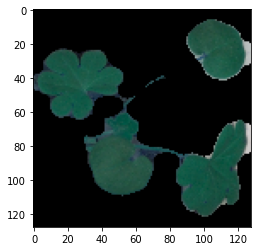

In [ ]:
#Visaulize Predictions for x_test[3]
i=3
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[0 0 0 0 0 0 0 0 0 0 1 0]
Predict:  Maize


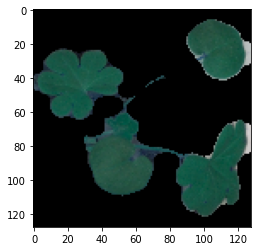

In [ ]:
#Visaulize Predictions for x_test[59]
i=3
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[0 0 0 0 0 0 1 0 0 0 0 0]
Predict:  Sugar beet


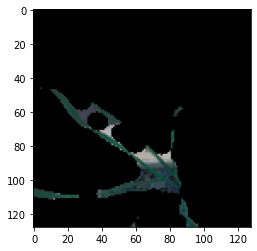

In [ ]:
#Visaulize Predictions for x_test[33]
i= 33
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[1 0 0 0 0 0 0 0 0 0 0 0]
Predict:  Loose Silky-bent


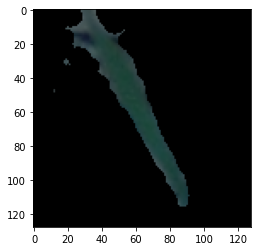

In [ ]:
#Visaulize Predictions for x_test[36]
i=36
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

label:[0 0 0 0 0 0 1 0 0 0 0 0]
Predict:  Sugar beet


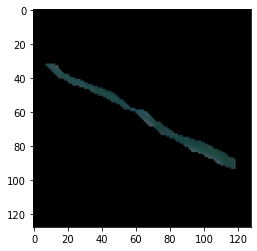

In [61]:
#Visaulize Predictions for x_test[40]
i=40
image = x_test[i]
label = y_test[i]
print(f'label:{label}')
where = label.tolist().index(1)
print('Predict: ',label_dict[where])
plt.imshow(image)

# **II : Transfer Learning **

In [68]:

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import VGG16
from PIL import Image

In [69]:
#Stream large image data sets using flow
datagen = ImageDataGenerator(validation_split=0.2)

train_generator = datagen.flow(x_train,
                               y_train,
                               batch_size=32,
                               shuffle=True,
                               seed=42,
                               subset='training')

valid_generator = datagen.flow(x_train,
                               y_train,
                               batch_size=32,
                               seed=42,
                               subset='validation')

In [86]:
base_model = DenseNet201(include_top=False, weights='imagenet',input_shape=(128,128,3),classes=y_train.shape[1]) 
base_model.trainable = False
transfer_model = tf.keras.Sequential()
transfer_model.add(base_model)
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(1024,activation=('relu'),kernel_initializer = 'he_uniform'))
transfer_model.add(layers.Dropout(0.4))
transfer_model.add(layers.Dense(512,activation=('relu'),kernel_initializer = 'he_uniform'))
transfer_model.add(layers.Dropout(0.4))
transfer_model.add(layers.Dense(128,activation=('relu'),kernel_initializer = 'he_uniform'))
transfer_model.add(layers.Dropout(0.4))
transfer_model.add(layers.Dense(128,activation=('relu'),kernel_initializer = 'he_uniform'))
transfer_model.add(layers.Dense(12,activation=('softmax')))
transfer_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten_4 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              31458304  
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)              

In [88]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# Let's train the model using Adam
transfer_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=12)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

batch_size = 32
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size

transfer_model_history = transfer_model.fit(
    train_generator,#train_generator.flow(x_train,y_train,batch_size=batch_size,shuffle=True,seed=42,subset='training'),
    epochs = 50,
    steps_per_epoch = step_size_train / batch_size,
    validation_data = valid_generator,#train_generator.flow(x_train,y_train,batch_size=batch_size,seed=42,subset='validation'),
    validation_steps = step_size_valid,
    verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50
2/2 [==============================] - 13s 3s/step - loss: 2.4389 - accuracy: 0.1849 - val_loss: 2.4340 - val_accuracy: 0.1359
Epoch 2/50
2/2 [==============================] - 1s 862ms/step - loss: 2.4692 - accuracy: 0.0742 - val_loss: 2.4363 - val_accuracy: 0.1344
Epoch 3/50
2/2 [==============================] - 1s 859ms/step - loss: 2.4501 - accuracy: 0.1276 - val_loss: 2.4359 - val_accuracy: 0.1297
Epoch 4/50
2/2 [==============================] - 1s 856ms/step - loss: 2.4090 - accuracy: 0.1198 - val_loss: 2.4352 - val_accuracy: 0.1375
Epoch 5/50
2/2 [==============================] - 1s 856ms/step - loss: 2.4387 - accuracy: 0.1641 - val_loss: 2.4373 - val_accuracy: 0.1297
Epoch 6/50
2/2 [==============================] - 1s 851ms/step - loss: 2.4974 - accuracy: 0.1289 - val_loss: 2.4367 - val_accuracy: 0.1328
Epoch 7/50
2/2 [==============================] - 1s 863ms/step - loss: 2.4432 - accuracy: 0.0612 - val_loss: 2.4335 - val_accuracy: 0.1344
Epoch 8/50
2/2 [======

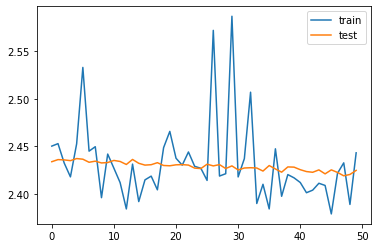

In [89]:
# plot training history
plt.plot(transfer_model_history.history['loss'], label='train')
plt.plot(transfer_model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [90]:
# Score trained model.
scores = transfer_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 6s 132ms/step - loss: 2.4173 - accuracy: 0.1374
Test loss: 2.4173433780670166
Test accuracy: 0.13744740188121796


**Conclusions:**
Given data, 12 species of different stages plant seedlings pictures by using the convolution neural networks(CNN)

dataset contains 4,750 128X128 color images in 12 different classes.
Loose Silky-bent, Common Chickweed, cats, Scentless Mayweed, Small-flowered Cranesbill, Fat Hen, Charlock, Sugar beet, Cleavers, Black-grass, Shepherds Purse,Maize, Common wheat.

Data set is splitted into training, validation and trsting as follows 3325 images for training, 713 images for validation , 712 images for testing.

Apply Gaussian blurring as part of preprocessing to soften sphere edges which often contain irregularities due to the rough surface of the marker.
Gaussian blurring is commonly used when reducing the size of an image. When downsampling an image, it is common to apply a low-pass filter to the image prior to resampling. This is to ensure that spurious high-frequency information does not appear in the downsampled image (aliasing).

Data is one hot encoded and normalised and data is reshaped to be compatible with Keras models.

CNN is a specialized linear operation on an image (a function), used for feature extraction (edges) and applied gaussian filter over the image is an pixel-wise product between each element of the filter and corresponding pixel in input image to feature map

Two key hyperparameters that define the convolution operation are size and number of kernel and tried with kernel size as 5X5 kernels and 128 group of kernels as filters.

Number of Parameters calculated as follows 5X5 (size)X3(ColourImage)X128(No of Filters) + 128(bias)
similarly number of parameters computers as above for the rest of the Convolution layers with batch normalisation and pooling layer is built with Max pooling and dropout with 20%, 30% and 40% of neurons to be considered in each layers. 

Sequential Model is built with Adam optimizer and classification entrophy as loss function with learning rate of .001.and relu activation funtion is used. Three layers of convolution and passed via max pooling before the output layer where softmax function as it is a classification problem.Accuracy is used as a metrics and model produced 82% accuracy in training and 73% accuracy in testing. Model checks for the accuracy improvements continously if there is no improvement in results it does early stopping to optimize the usage of resources/ computation cost.

Confusion matrix is built and precision with 80%, recall and f1 score as 73%.

Test images are predicted correctly they are 
Loose Silky-bent, Charlock, Sugar beet, Maize checked with their labels from the original image and its predicted image.

Tranfer Learning Model is built with DenseNet201 but there is no much improved result with respect to accuracy. Sequential model with three layers of convolution and pooling layer produced better result by considering the gaussian blurred color image and predicted with 80% of accuracy.
